# DEA CoastLines utility functions

## Load modules/functions


In [7]:
import matplotlib.pyplot as plt
import geopandas as gpd 
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles
from shapely.geometry import box
import matplotlib.colors as colors

def rates_hist(stats_path, 
               extent_path=None,
               cmap='RdBu',
               hist_log=True, 
               hist_bins=60, 
               hist_range=(-30, 30)):
    """
    Function for analysing DEACoastLines statistics point data, plotting 
    resules as histograms to compare rates of change.
    
    Parameters
    ----------
    stats_path : string
        Path to DEACoastLines statistics point vector file (e.g. 
        DEACoastLines_statistics_ntwa.shp')
    extent_path : string, optional
        An optional path to a shapefile or other vector file that will be used
        to extract a subset of DEACoastLines statistics. The default is None,
        which will select a subset of data using an interactive map.
    hist_log : boolean, optional
        An optional boolean indicating whether to plot histograms with a log 
        y-axis. If True, all non-significant statistics points will be assigned
        a rate of 0 metres / year. If False, all non-significant points will 
        be removed from the dataset, and plotted with a linear y-axis.    
    """
    
    if extent_path:
        extent = gpd.read_file(extent_path)

    else:
        # Plot interactive map to select area
        basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
        geopolygon = select_on_a_map(height='600px',
                                     layers=(basemap,),
                                     center=(-26, 135), 
                                     zoom=4) 

        # Covert extent object to geopandas.GeoSeries object with CRS
        extent = box(*geopolygon.boundingbox)
        extent = gpd.GeoSeries(extent, crs='EPSG:4326')

    # Extract corresponding portion of stats file
    stats_subset = gpd.read_file(stats_path, bbox=extent)
    
    # Raise exception if no points are returned
    if len(stats_subset.index) == 0:
        raise ValueError('No statistics points were returned for the supplied '
                         'extent. Please select another area, or specify a '
                         'points statistics file that covers the area you are '
                         'interested in.')

    if hist_log:

        print('Plotting data with log axis after setting non-significant points to 0 m / year')
        stats_subset.loc[stats_subset.sig_time > 0.01, 'rate_time'] = 0

    else:
        print('Plotting data with linear axis after filtering to significant values')
        stats_subset = stats_subset.loc[stats_subset.sig_time < 0.01]

    # Select colormap
    cm = plt.cm.get_cmap(cmap)

    # Create figure
    fig = plt.figure(figsize=(10, 6))
    plt.grid(True, which="both", axis='y', color='0.9')
    plt.gca().set_axisbelow(True)

    # Plot histogram
    bin_offset = (hist_range[1] - hist_range[0]) / (hist_bins / 0.5)
    n, bins, patches = plt.hist(stats_subset.rate_time, 
                                bins=hist_bins, 
                                range=[(a + bin_offset) for a in hist_range], 
                                log=hist_log,
                                edgecolor='black')

    # Scale values to interval [0,1]
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    norm = colors.SymLogNorm(linthresh=0.5, 
                             linscale=0.05,
                             vmin=hist_range[0], 
                             vmax=hist_range[1], 
                             base=10)
    col = norm(bin_centers)  

    # Apply colors to bars
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))

    plt.title(f'Mean rate: {stats_subset.rate_time.mean():.2f} m / year')
    plt.xlabel('Rate of change (m / year)')
    plt.ylabel('Frequency')
    plt.show()

## Histogram analysis



Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

Plotting data with log axis after setting non-significant points to 0 m / year


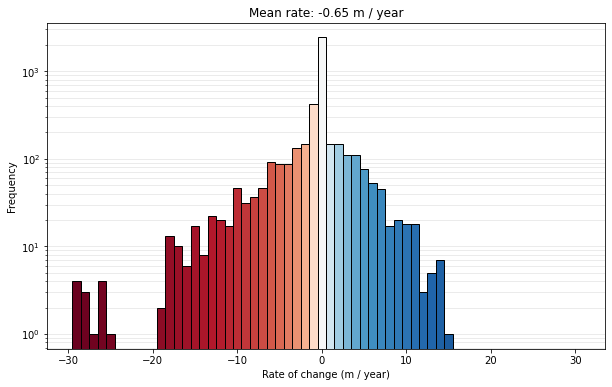

In [10]:
stats_path='/g/data/r78/rt1527/dea-notebooks/MAHTS/DEACoastLines_statistics_ntwa.shp'
# stats_path='/g/data/r78/rt1527/dea-notebooks/MAHTS/DEACoastLines_statistics_nsqqld.shp'
# stats_path='/g/data/r78/rt1527/dea-notebooks/MAHTS/DEACoastLines_statistics_tasvicsa.shp'

rates_hist(stats_path=stats_path, hist_log=True)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** March 2020